# Imports

The required packages to run this notebook.  
If any are missing use ``!{sys.executable} -m pip install <package>`` to install the package in the notebook environment

In [1]:
import os.path
import gc 
import pandas as pd
import csv
import sys
from ctypes import cdll, CDLL
from urllib import parse
#!{sys.executable} -m pip install beautifulsoup4
from bs4 import BeautifulSoup
#!{sys.executable} -m pip install nbimporter
import nbimporter
import ARCH_Helper as ah
#!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
import multiprocessing
import time

# Download an archive
The script below makes a data folder with a subfolder for the dataset. Dataset option are "World", "German" or "Dutch", select these by altering the ``dataset`` variable. The script wil skip files that are already present on the system. If you want to redownload the files first remove the old files manually.  
If the download fails due to connection errors, rerun the script and will will notice that he file did not decompress and try again.  
Note: The html-file-information.csv can be very large and take several hours and fail. Consider putting the code below code in a loop if you want to run it over night, if the download fails it will try again and if successfull it will say it already has the desired file.

In [2]:
# Dataset option are "World", "German" or "Dutch"
Dataset = "Dutch"

!mkdir data
!mkdir data/{Dataset}
!mkdir data/{Dataset}/results

if Dataset == "German":
    if not os.path.exists("data/German/domain-frequency.csv"):
        print("domain-frequency.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/DomainFrequencyExtraction/domain-frequency.csv.gz?access=VRQ4COI5RFEB6XTJZNQTBRLEZTTHJERL" --output data/German/domain-frequency.csv.gz
        print("domain-frequency.csv has been downloaded")
    else:
        print("domain-frequency.csv already exists")

    if not os.path.exists("data/German/domain-graph.csv"):
        print("domain-graph.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/DomainGraphExtraction/domain-graph.csv.gz?access=JKEPGQ6MUC72JQB23IXOC4KOLGJYDSMN" --output data/German/domain-graph.csv.gz
        print("domain-graph.csv has been downloaded")
    else:
        print("domain-frequency.csv already exists")

    if not os.path.exists("data/German/css-file-information.csv"):
        print("css-file-information.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/css-file-information.csv.gz?access=I2WP4REJA3NOBU3TCAAL3OIGJKNXM46R" --output data/German/css-file-information.csv.gz
        print("css-file-information.csv has been downloaded")
    else:
        print("css-file-information.csv already exists")

    if not os.path.exists("data/German/js-file-information.csv"):
        print("js-file-information.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/js-file-information.csv.gz?access=M3QSMFPLEHPZPWZIFSMZ6CT2OO7WYQ4M" --output data/German/js-file-information.csv.gz
        print("css-file-information.csv has been downloaded")
    else:
        print("js-file-information.csv already exists")
        
    if not os.path.exists("data/German/html-file-information.csv"):
        print("html-file-information.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/html-file-information.csv.gz?access=E3BUHKL5P4Q3TD4LGXZV2AOMERYQ3GWL" --output data/German/html-file-information.csv.gz
        print("html-file-information.csv has been downloaded")
    else:
        print("html-file-information.csv already exists")
        
if Dataset == "World":
    if not os.path.exists("data/World/domain-frequency.csv"):
        print("domain-frequency.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/DomainFrequencyExtraction/domain-frequency.csv.gz?access=SMSQY3G6IGKGRWVLGCWMA7DMCHBCKQ4K" --output data/World/domain-frequency.csv.gz
        print("domain-frequency.csv has been downloaded")
    else:
        print("domain-frequency.csv already exists")

    if not os.path.exists("data/World/domain-graph.csv"):
        print("domain-graph.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/DomainGraphExtraction/domain-graph.csv.gz?sample=true&access=BZTA7LW5LUNMPGKWQMLKAUAXBV2E2AEC" --output data/World/domain-graph.csv.gz
        print("domain-graph.csv has been downloaded")
    else:
        print("domain-frequency.csv already exists")

    if not os.path.exists("data/World/css-file-information.csv"):
        print("css-file-information.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/css-file-information.csv.gz?access=UZ4PWVRXXWPF53BHM7TTYNK24P7YAIXQ" --output data/World/css-file-information.csv.gz
        print("css-file-information.csv has been downloaded")
    else:
        print("css-file-information.csv already exists")

    if not os.path.exists("data/World/js-file-information.csv"):
        print("js-file-information.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/js-file-information.csv.gz?access=54X7IV7QOOAJWGHKPRGDI7HIR6W6GKPI" --output data/World/js-file-information.csv.gz
        print("css-file-information.csv has been downloaded")
    else:
        print("js-file-information.csv already exists")
    
    if not os.path.exists("data/World/html-file-information.csv"):
        print("html-file-information.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/html-file-information.csv.gz?access=JQEDT3PRXOS6OXZ7LA5EC55HQJVUASDX" --output data/World/html-file-information.csv.gz
        print("html-file-information.csv has been downloaded")
    else:
        print("html-file-information.csv already exists")

if Dataset == "Dutch":
    if not os.path.exists("data/Dutch/domain-frequency.csv"):
        print("domain-frequency.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/DomainFrequencyExtraction/domain-frequency.csv.gz?access=QUQTRHVNIDKXN62S4D62XFHCFI7VDSH7" --output data/Dutch/domain-frequency.csv.gz
        print("domain-frequency.csv has been downloaded")
    else:
        print("domain-frequency.csv already exists")

    if not os.path.exists("data/Dutch/domain-graph.csv"):
        print("domain-graph.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/DomainGraphExtraction/domain-graph.csv.gz?access=JUNESOMDTBYDNCCGVJI5MJHW45KHAIJZ" --output data/Dutch/domain-graph.csv.gz
        print("domain-graph.csv has been downloaded")
    else:
        print("domain-frequency.csv already exists")

    if not os.path.exists("data/Dutch/css-file-information.csv"):
        print("css-file-information.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/TextFilesInformationExtraction/css-file-information.csv.gz?access=IGBKSGXJBL3L4IJ2LXS5NPJTOY77JCT5" --output data/Dutch/css-file-information.csv.gz
        print("css-file-information.csv has been downloaded")
    else:
        print("css-file-information.csv already exists")

    if not os.path.exists("data/Dutch/js-file-information.csv"):
        print("js-file-information.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/TextFilesInformationExtraction/js-file-information.csv.gz?access=RPZKGWUTWJBIRKOKKHGECB7W4OHUATMO" --output data/Dutch/js-file-information.csv.gz
        print("css-file-information.csv has been downloaded")
    else:
        print("js-file-information.csv already exists")
    
    if not os.path.exists("data/Dutch/html-file-information.csv"):
        print("html-file-information.csv is not present")
        !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/TextFilesInformationExtraction/html-file-information.csv.gz?access=52ZOSNQQMFWKW42WMQPNMGKYLEVUQHUC" --output data/Dutch/html-file-information.csv.gz
        print("html-file-information.csv has been downloaded")
    else:
        print("html-file-information.csv already exists")

unzip = "find data/" +Dataset +" -name '*.gz' -exec gunzip {} \;"
!{unzip}

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/Dutch’: File exists
mkdir: cannot create directory ‘data/Dutch/results’: File exists
domain-frequency.csv already exists
domain-frequency.csv already exists
css-file-information.csv already exists
js-file-information.csv already exists
html-file-information.csv already exists


Reduce the total dataset to only the domains that fit the research scope

The ``chunksize`` variable determines how much memory is used. A larger chunksize allows for faster computation, but will crash when RAM is full. If the computation crashes try restarting the kernel and/or a lower chunksize. A chunksize of 1000 should be fine for most machines.

In [3]:
chunksize = 1000
dataset_location = "data/"+Dataset +"/html-file-information.csv"
dataset_in_scope_location = dataset_location[:-4]+"-in-scope.csv"


if Dataset == "Dutch":
    domains_in_scope = ["https://fd.nl/","https://www.ad.nl","https://www.nd.nl/","https://www.nrc.nl/","https://www.rd.nl/","https://www.telegraaf.nl/","https://www.trouw.nl","https://www.volkskrant.nl/","https://www.ewmagazine.nl/","https://www.bd.nl","https://www.bndestem.nl","https://www.destentor.nl","https://www.dvhn.nl","https://www.ed.nl","https://www.gelderlander.nl","https://www.haarlemsdagblad.nl/","https://www.lc.nl/","https://www.leidschdagblad.nl/","https://www.limburger.nl","https://www.noordhollandsdagblad.nl","https://www.parool.nl","https://www.pzc.nl","https://www.tubantia.nl","https://jeugdjournaal.nl/","https://nieuws.nl/","https://nos.nl/","https://www.1limburg.nl/","https://www.businessinsider.nl/","https://www.dutchnews.nl/","https://www.ewmagazine.nl/","https://www.geenstijl.nl/","https://www.kliknieuws.nl/","https://www.metronieuws.nl/","https://www.nhnieuws.nl/","https://www.ninefornews.nl/","https://www.nu.nl/","https://www.quotenet.nl","https://www.rtlnieuws.nl","https://www.tpo.nl","https://www.welingelichtekringen.nl","https://www.hartvannederland.nl/","https://www.bnr.nl/","https://www.dagelijksestandaard.nl/","http://www.joop.nl/","https://www.hpdetijd.nl/","https://www.groene.nl/","https://www.oneworld.nl/","https://www.vn.nl/","https://sargasso.nl/","https://www.powned.tv/"]
    domains_in_scope = list(map(ah.to_domain, domains_in_scope))
if Dataset == "World":
    domains_in_scope = ["https://cnn.com","https://www.nytimes.com/","https://www.theguardian.com/","https://www.indiatimes.com/","https://www.foxnews.com/","https://www.washingtonpost.com/","https://usatoday.com","https://www.cnbc.com","http://www.chinadaily.com.cn/","https://www.thehindu.com/","https://www.wsj.com","https://nypost.com/","https://www.huffingtonpost.com","https://abcnews.go.com/","https://www.bbc.com/","https://www.dailymail.co.uk/","https://timesofindia.indiatimes.com/","https://www.independent.co.uk/","https://www.smh.com.au/","https://www.telegraph.co.uk/","https://www.latimes.com/","https://www.sfgate.com/","https://www.nbcnews.com/","https://buzzfeednews.com","https://aljazeera.com","https://rt.com","https://reuters.com","https://npr.org","https://sputniknews.com","https://cbsnews.com","https://cbc.ca","https://abc.net.au","https://time.com","https://mirror.co.uk","https://thesun.co.uk","https://euronews.com","https://ctvnews.ca","https://vox.com","https://scmp.com","https://france24.com","https://express.co.uk","https://news.sky.com","https://news24.com","https://globalnews.ca","https://channelnewsasia.com","https://rawstory.com","https://washingtontimes.com","https://todayonline.com","https://dailytelegraph.com.au","https://csmonitor.com"]
    domains_in_scope = list(map(ah.to_domain, domains_in_scope))
if Dataset == "German":
    domains_in_scope = ["https://www.bild.de","https://www.waz.de","https://www.zeit.de/","https://www.sueddeutsche.de","https://www.welt.de/","https://rp-online.de/","https://www.faz.net/","https://www.augsburger-allgemeine.de/","https://www.allgaeuer-zeitung.de/","https://www.freiepresse.de","https://www.merkur.de","https://www.lvz.de","https://www.mz.de","https://www.wn.de","https://www.hna.de","https://www.rheinpfalz.de","https://www.volksstimme.de","https://www.handelsblatt.com","https://taz.de","https://www.nd-aktuell.de","https://jungefreiheit.de","https://www.freitag.de","http://www.das-parlament.de","https://www.juedische-allgemeine.de","https://www.fr.de","https://www.abendblatt.de","https://www.morgenpost.de","https://www.tagesspiegel.de","https://www.bz-berlin.de","https://www.ftd.de","https://www.ksta.de/","https://www.stuttgarter-zeitung.de","https://www.badische-zeitung.de","https://www.tz.de","https://www.mopo.de","https://www.berliner-zeitung.de","https://www.haz.de","https://www.stuttgarter-nachrichten.de","http://www.spiegel.de/","https://www.deutschlandfunk.de/","https://www.focus.de/","https://www.stern.de/","https://www.zdf.de/","https://wdr.de/","https://www.ndr.de/","https://www.br.de/","https://www.swr.de/","https://www.mainpost.de/","https://www.nwzonline.de/","https://mads.de/"]
    domains_in_scope = list(map(ah.to_domain, domains_in_scope))
if not os.path.exists(dataset_in_scope_location):
    ah.filter_csv_domains(dataset_location, dataset_in_scope_location, domains_in_scope, chunksize)


# Extract wepages holding signs of commenting systems in their HTML

``detection_patterns`` is a csv file holding the commenting systems and their detection patterns

In [4]:
detection_patterns = pd.read_csv("Commenting-system-detection-patterns.csv")

The code bellow loops through the known commenting systems and their detection patterns, saving them per commenting system in a CSV file at ``"data/"+Dataset +"/results/"+system+".csv"`` and a summary file at ``"data/"+Dataset +"/results/"+system+"-summary.csv"``

In [5]:
def detect_system(system):
    system_df_list = []
    for index, row in detection_patterns[detection_patterns['Commenting system'] == system].iterrows():
        system_df = ah.filter_csv_content_regex(dataset_in_scope_location, row['Regex'], chunksize)
        system_df[row['Snipit']]=True
        system_df_list.append(system_df)

    system_df = pd.concat(system_df_list)
    
    system_df["year"] = system_df["crawl_date"].div(10000).round().astype(int)
    system_df["domain"] = system_df['url'].apply(ah.to_domain)
    
    system_df = system_df.fillna(False)
    
    save_location = "data/"+Dataset +"/results/"+system+".csv"
    ah.save_dataframe(system_df, save_location)
    
    snippits = list(detection_patterns[detection_patterns['Commenting system'] == system]['Snipit'])
    result_scope = ['year','domain']
    result_scope.extend(snippits)
    
    system_results = pd.DataFrame(system_df[result_scope].value_counts().sort_index()).reset_index()
    system_results.rename(columns={0:'count'}, inplace=True)
    
    save_location = "data/"+Dataset +"/results/"+system+"-summary.csv"
    ah.save_dataframe(system_results, save_location)
    

systems = list(detection_patterns['Commenting system'].unique())
pool = multiprocessing.Pool(12)
pool.map(detect_system, systems)
pool.close()

Display extended summeries for each of the commenting systems

Overlap between identifiers for Disqus:

data-disqus-identifier  disqus.com/embed.js  disqus_thread
False                   False                True             64
                        True                 False            36
True                    False                False            33
dtype: int64


haarlemsdagblad.nl uses  Disqus  in: [2011, 2012, 2013, 2014]
nrc.nl uses  Disqus  in: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2019]
vn.nl uses  Disqus  in: [2011, 2012, 2013, 2014, 2015]
leidschdagblad.nl uses  Disqus  in: [2012, 2013, 2014, 2015]
noordhollandsdagblad.nl uses  Disqus  in: [2012, 2013, 2014, 2015, 2016]
nos.nl uses  Disqus  in: [2012, 2013, 2014]
dutchnews.nl uses  Disqus  in: [2013, 2014, 2015, 2016, 2017, 2019]
hpdetijd.nl uses  Disqus  in: [2013, 2014, 2015, 2016]
quotenet.nl uses  Disqus  in: [2013, 2014, 2015, 2016, 2017]
welingelichtekringen.nl uses  Disqus  in: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
nieuws.nl uses  Disqus  in: [2014, 2016, 2017, 2018,

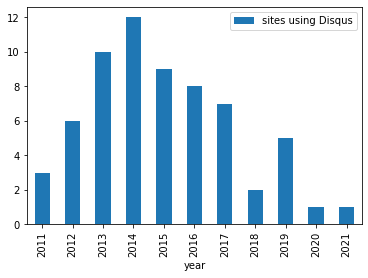

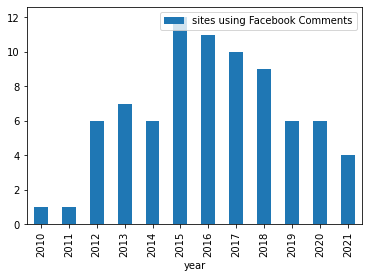

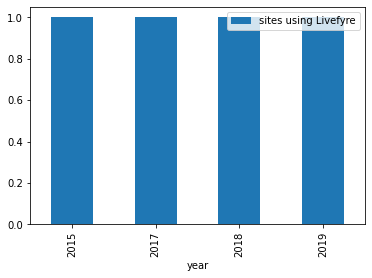

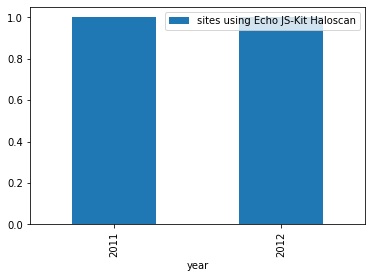

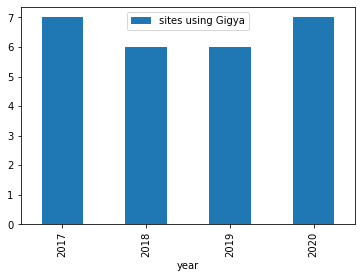

In [6]:
for system in list(detection_patterns['Commenting system'].unique()):
    save_location = "data/"+Dataset +"/results/"+system+"-summary.csv"
    results = pd.read_csv(save_location)
    domains = list(results.domain.unique())
    
    #skip to next itteration if no domains found with system
    if domains == []:
        continue

    identifiers = results.columns.values.tolist()
    identifiers = [x for x in identifiers if x not in ['year','domain','count']]
    print("Overlap between identifiers for "+system+":")
    print()
    print(results[identifiers].value_counts())
    print()
    
    print()
    for domain in domains:
        years = list(results[results.domain == domain].year.unique())
        print(domain, "uses ", system," in:", years)
    
    print()
    print("Number of sites using "+system+" per year:")
    sites_per_year = pd.DataFrame(results[["year", "domain"]].drop_duplicates()["year"].value_counts().sort_index()).reset_index()
    sites_per_year.columns = ["year", "sites using "+system ]
    
    print(sites_per_year)
    sites_per_year.plot(x='year', kind = 'bar')
    print()

Display commenting systems per year

<AxesSubplot:xlabel='year'>

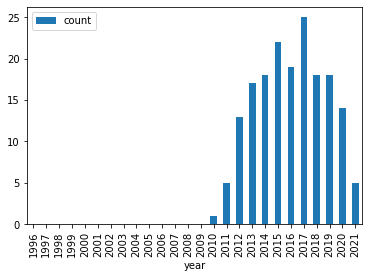

In [7]:
years = range(1996,2022)
commenting_systems_per_year = pd.DataFrame(0,index=[list(years)], columns=["count"])

for system in list(detection_patterns['Commenting system'].unique()):
    save_location = "data/"+Dataset +"/results/"+system+"-summary.csv"
    results = pd.read_csv(save_location)
    domains = list(results.domain.unique())
    
    #skip to next itteration if no domains found with system
    if domains == []:
        continue

    for domain in domains:
        years_in_system = list(results[results.domain == domain].year.unique())
        for year in years_in_system:
            commenting_systems_per_year.loc[year, 'count'] += 1

commenting_systems_per_year = commenting_systems_per_year.reset_index(level=0)
commenting_systems_per_year.columns = ["year", "count"]
commenting_systems_per_year.plot(x='year', kind = 'bar')

Display a matrix with the commenting system per domain per year

In [8]:
years = range(1996,2022)
commenting_systems_per_domain = pd.DataFrame(index=[list(years)], columns=[domains_in_scope])
#commenting_systems_per_year = commenting_systems_per_year.fillna("")

for system in list(detection_patterns['Commenting system'].unique()):
    save_location = "data/"+Dataset +"/results/"+system+"-summary.csv"
    results = pd.read_csv(save_location)
    domains = list(results.domain.unique())
    
    #skip to next itteration if no domains found with system
    if domains == []:
        continue

    for domain in domains:
        years_in_system = list(results[results.domain == domain].year.unique())
        for year in years_in_system:
            #print(commenting_systems_per_year.loc[year, domain].dropna().empty)
            if commenting_systems_per_domain.loc[year, domain].dropna().empty:
                commenting_systems_per_domain.loc[year, domain] = system
            else :
                tmp = commenting_systems_per_domain.loc[year, domain] + "; " + system
                commenting_systems_per_domain.loc[year, domain] = tmp

commenting_systems_per_domain = commenting_systems_per_domain.fillna("").transpose()
save_location = "data/"+Dataset +"/results/domain-summary.csv"
commenting_systems_per_domain.to_csv(save_location)
commenting_systems_per_domain

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
fd.nl,,,,,,,,,,,...,,,,,,,,,,
ad.nl,,,,,,,,,,,...,,,,,,Gigya,Gigya,Gigya,Gigya,
nd.nl,,,,,,,,,,,...,,,,,,,,,Facebook Comments,Facebook Comments
nrc.nl,,,,,,,,,,,...,Disqus,Disqus,Disqus,Disqus,Disqus,Disqus,,Disqus,,
rd.nl,,,,,,,,,,,...,,,,,,,,,,
telegraaf.nl,,,,,,,,,,,...,Facebook Comments,Facebook Comments,,Facebook Comments; Livefyre,Facebook Comments,Livefyre,Livefyre,Livefyre,,
trouw.nl,,,,,,,,,,,...,,,,,,,,,,
volkskrant.nl,,,,,,,,,,,...,,,,,,,,,,
ewmagazine.nl,,,,,,,,,,,...,,,,,,,,,,
bd.nl,,,,,,,,,,,...,,,,,,Gigya,Gigya,Gigya,Gigya,


# For the found Disqus pages extract the comment structure

Extract the disqus comments from the div tag with ```id="disqus_thread"```

In [9]:
disqus_df = pd.read_csv("data/"+Dataset +"/results/Disqus.csv")

comments = []
for line in disqus_df.content:
    soup = BeautifulSoup(line, 'html.parser')
    try:
        comments.append(soup.find('div', attrs={'id': 'disqus_thread'}).prettify()) # .prettify() makes the HTML of the comments more human readable
    except AttributeError:
        comments.append("")
        
disqus_df['comments'] = comments

In [10]:
#pd.set_option('display.max_colwidth', 500) 
disqus_df[['crawl_date','url','comments']]

,crawl_date,url,comments
0,20120206,http://www.noordhollandsdagblad.nl/nieuws/econ...,"<div id=""disqus_thread"">\n</div>\n"
1,20120204,http://www.noordhollandsdagblad.nl/nieuws/econ...,"<div id=""disqus_thread"">\n</div>\n"
2,20120205,http://www.noordhollandsdagblad.nl/nieuws/spor...,"<div id=""disqus_thread"">\n</div>\n"
3,20120202,http://www.noordhollandsdagblad.nl/nieuws/spor...,"<div id=""disqus_thread"">\n</div>\n"
4,20120205,http://www.noordhollandsdagblad.nl/nieuws/spor...,"<div id=""disqus_thread"">\n</div>\n"
...,...,...,...
9146,20120128,http://www.vn.nl/boeken/schrijver/de-giftige-w...,"<div id=""disqus_thread"">\n</div>\n"
9147,20130311,http://www.vn.nl/boeken/schrijver/ramsey-nasr-...,"<div id=""disqus_thread"">\n <div id=""dsq-conten..."
9148,20120512,http://www.vn.nl/boeken/theater-2/actrice-anni...,"<div id=""disqus_thread"">\n</div>\n"
9149,20120512,http://www.vn.nl/boeken/theater-2/wij-zijn-all...,"<div id=""disqus_thread"">\n</div>\n"


# Add an internet archive URL to the dataframe

In [11]:
ah.add_ia_url(disqus_df)

Filter out comment fields that are so short that they do net contain comments (based on the length).  
32 characters is currently the shortest 

In [12]:
#pd.set_option('display.max_colwidth', 50)
disqus_df[disqus_df['comments'].apply(lambda x: len(x)>32)][['comments','IA_url']]

,comments,IA_url
684,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20140712/http://ww...
685,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20150110/http://ww...
686,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20150111/http://ww...
687,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20160202/http://ww...
688,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20140413/http://ww...
...,...,...
9126,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20120420/http://ww...
9136,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20110817/http://ww...
9137,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20110902/http://ww...
9143,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20110720/http://ww...


Display a specific comment

In [13]:
ah.display_comment(disqus_df, 0)

<div id="disqus_thread">
</div>



# Comparing dataframes

Creates a second dataframe with a different regex query 

In [14]:
#disqus_df_2 = ah.filter_csv_content_regex("data/World/html-file-information.csv", "(?i)disqus\.js", 10000)

Show the overlap of two dataframes

In [15]:
#ah.dataframe_intersection(disqus_df[['crawl_date','url']],disqus_df_2[['crawl_date','url']])

Show the difference between the two datasets. So only shows results that are in one dataset but not in both.

In [16]:
#ah.dataframe_difference(disqus_df[['crawl_date','url']],disqus_df_2[['crawl_date','url']])

# Testing scratchbook

Reloads the ARCH Helper module after update.  
Normally this would be done with autoreload Ipython magic, but for some reason it does not work. 

In [17]:
import importlib
importlib.reload(ah)
import ARCH_Helper as ah